In [591]:
import numpy as np
import xgboost as xgb
import pandas as pd
pd.options.display.max_columns = None
from utils import create_time_series_splits
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_parquet('../data/datasets_2023-2025_beta.parquet')
df.timestamp = pd.to_datetime(df.timestamp, unit = 's')
usd_coins = ["DAIUSD_720.parquet", "USDCUSD_720.parquet", "USDTUSD_720.parquet", "USTUSD_720.parquet"]
currencies = ["AUDUSD_720.parquet", "EURUSD_720.parquet", "GBPUSD_720.parquet"]
commodities = ['PAXGUSD_720.parquet']

df = df[~df.filename.isin(usd_coins + currencies + commodities)]
df['log_return'] = df.groupby('filename')['close'].transform(lambda x: np.log(x / x.shift(1)))
df['next_return'] = df.groupby('filename')['log_return'].shift(-1)
df = df[df['log_return'].notna()]
df = df[df['next_return'].notna()]
df['filename_id'] = df.filename.astype('category')

### One model for all

In [ ]:
train_dfs, test_dfs = create_time_series_splits(df, date_column='timestamp', months_train=12, months_test=0.25)
# train_dfs = [train_dfs[-1]]
# test_dfs = [test_dfs[-1]]
all_preds = []
feature_importances = []

for train_df, test_df in zip(train_dfs, test_dfs):
    X_train = train_df.drop(columns=['next_return', 'timestamp', 'filename'])
    y_train = train_df['next_return']
    X_test = test_df.drop(columns=['next_return', 'timestamp', 'filename'])
    y_test = test_df['next_return']

    # X_val = X_train[int(len(X_train)* 0.8):]
    # y_val = y_train[int(len(y_train)* 0.8):]
    # X_train = X_train[: int(len(X_train)* 0.8)]
    # y_train = y_train[: int(len(y_train)* 0.8)]
    
    # # Return weighting
    # abs_ret = np.abs(y_train)
    # w = 0.1 + abs_ret / abs_ret.mean()
    # w = np.log(w + 1) / np.mean(np.log(w + 1))
    
    # # Time based weighting
    # max_ts = train_df['timestamp'].max()
    # age_days = (max_ts - train_df['timestamp']).dt.total_seconds() / (3600 * 24)
    # w = 0.995 ** age_days.values

    # # Volume based weighting
    # tmp = X_train['volume'] * X_train['close']
    # w = (np.log(tmp) - np.log(tmp.mean())) / np.log(tmp).std()
    # w = np.array(np.exp(w))

    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.01,
        enable_categorical=True,
        objective='reg:pseudohubererror',
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)

    # X_val['err2'] = (model.predict(X_val) - y_val) ** 2
    # weight_schema = np.exp(2 * X_val.drop(columns=['filename_id']).corr()['err2'][:-1])
    # final_x_train = pd.concat([X_train, X_val])
    
    # scaler = StandardScaler()
    # scaler.fit(final_x_train.drop(columns=['filename_id']))
    # final_x_train_scaled = scaler.transform(final_x_train.drop(columns=['filename_id']))
    # final_x_train_scaled = pd.DataFrame(final_x_train_scaled, columns=final_x_train.drop(columns=['filename_id']).columns)

    # final_x_train_scaled['weights'] = sum([weight_schema[col] * final_x_train_scaled[col] for col in weight_schema.index])
    # final_x_train['weights'] = list(final_x_train_scaled['weights'])
    # final_y_train = np.concatenate([y_train, y_val])
    # final_x_train.drop(columns='err2', inplace=True)

    # model = xgb.XGBRegressor(
    #     n_estimators=100,
    #     max_depth=5,
    #     learning_rate=0.01,
    #     enable_categorical=True,
    #     objective='reg:pseudohubererror',
    #     random_state=42,
    #     n_jobs=-1,
    # )
    # model.fit(final_x_train.drop(columns=['weights']), final_y_train, sample_weight=np.exp((final_x_train['weights'] - final_x_train['weights'].mean()) / final_x_train['weights'].std()))
    preds = model.predict(X_test)
    test_df['pred'] = preds
    all_preds.append(test_df[['timestamp', 'filename', 'pred', 'next_return']])
    feature_importances.append(model.feature_importances_)
all_preds_df = pd.concat(all_preds, ignore_index=True)
all_preds_df.to_parquet('XGB_predictions_one_model.parquet', index=False)

In [645]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0268, MSE: 0.0017, R2: 0.0054, RMSE: 0.0414


In [ ]:
# Huber 2: MAE: 0.0268, MSE: 0.0017, R2: 0.0048, RMSE: 0.0414
# Huber 1: MAE: 0.0268, MSE: 0.0017, R2: 0.0058, RMSE: 0.0414

In [345]:
all_preds_df['error'] = (all_preds_df['pred'] - all_preds_df['next_return']) ** 2

In [346]:
merged = pd.merge(
    df,
    all_preds_df,
    on=['timestamp', 'filename'],
)
floats = merged[merged.select_dtypes(include=['float64']).columns]
floats.drop(columns = ['next_return_x', 'next_return_y'], inplace=True)

In [369]:
floats.corr()['error'].sort_values(ascending=False)

error                  1.000000
log_price_range        0.239737
close_to_low           0.232847
realized_vol_14        0.213170
weighted_vol_14        0.191835
return                 0.109627
log_return             0.065230
volume_zscore_14       0.052300
trades                 0.033061
mom_2_1                0.030400
mom_36_13              0.012078
volume                 0.009839
mom_14_2               0.009205
mom_12_7               0.006758
ma_zscore_14           0.006052
volume_change          0.002449
rsi                    0.001751
macd_hist             -0.000143
amihud_14             -0.007105
high                  -0.010402
close                 -0.010640
open                  -0.010686
vwap_14               -0.010690
low                   -0.010914
sto_osc_14            -0.011396
ltrev_28              -0.016103
beta_market           -0.055300
strev_6               -0.094984
close_to_high         -0.151775
price_ema_diff_14     -0.250574
ema_diff_norm_10_21   -0.345615
ema_diff

In [358]:
X_train = floats[:int(len(floats) * 0.8)].drop(columns=['error'])
y_train = floats[:int(len(floats) * 0.8)]['error']
X_test = floats[int(len(floats) * 0.8):].drop(columns=['error'])
y_test = floats[int(len(floats) * 0.8):]['error']
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [359]:
r2_score(y_test, preds), mean_squared_error(y_test, preds), mean_absolute_error(y_test, preds)

(0.01377551965281465, 0.00016850268388367856, 0.0032851748944720347)

In [364]:
X_test.columns[model.coef_.argsort()]

Index(['close_to_high', 'log_price_range', 'ema_diff_norm_10_21', 'log_return',
       'weighted_vol_14', 'mom_2_1', 'amihud_14', 'strev_6', 'mom_14_2',
       'ema_diff_norm_20_50', 'ltrev_28', 'ma_zscore_14', 'beta_market',
       'volume_zscore_14', 'macd_hist', 'volume_change', 'open', 'high',
       'vwap_14', 'trades', 'volume', 'close', 'sto_osc_14', 'low', 'rsi',
       'mom_36_13', 'mom_12_7', 'realized_vol_14', 'price_ema_diff_14',
       'return', 'close_to_low'],
      dtype='object')

In [365]:
model.coef_.argsort()

array([ 9, 11, 19,  6, 24, 13, 29, 17, 14, 20, 18, 12, 30, 25, 22,  8,  0,
        1, 26,  5,  4,  3, 27,  2, 28, 16, 15, 23, 21,  7, 10])

In [366]:
model.coef_

array([-2.04491240e-06, -1.37433222e-06,  3.48946851e-06,  3.77638771e-07,
       -6.62617520e-15, -5.60411095e-08, -4.44201496e-02,  5.07174655e-02,
       -2.80797665e-06, -3.44147300e-01,  2.99680923e-01, -2.94002209e-01,
       -9.09147792e-04, -1.81708479e-02, -4.57213908e-03,  3.76909744e-03,
        1.89149456e-03, -9.62627528e-03, -2.69598003e-03, -4.93703558e-02,
       -3.77430551e-03,  1.96672648e-02, -5.37528338e-06,  1.12189457e-02,
       -1.95878576e-02, -2.08189183e-04, -2.94192306e-07,  3.89466387e-07,
        5.57130886e-05, -1.63947805e-02, -2.74308134e-04])

In [311]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0269, MSE: 0.0017, R2: 0.0008, RMSE: 0.0415


In [284]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0268, MSE: 0.0017, R2: 0.0048, RMSE: 0.0414


In [246]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0268, MSE: 0.0017, R2: 0.0046, RMSE: 0.0414


In [221]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0268, MSE: 0.0017, R2: 0.0046, RMSE: 0.0414


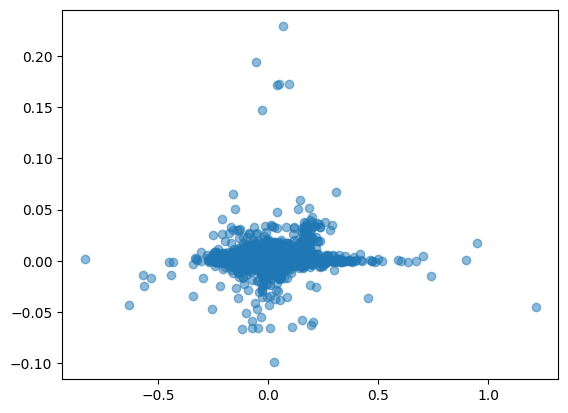

In [550]:
plt.scatter(all_preds_df['next_return'], all_preds_df['pred'], alpha=0.5)

In [423]:
all_preds_df.groupby('filename').apply(
    lambda x: pd.Series({
        'mse': mean_squared_error(x['next_return'], x['pred']),
        'mae': mean_absolute_error(x['next_return'], x['pred']),
        'r2': r2_score(x['next_return'], x['pred'])
    })
).reset_index().sort_values('r2')

,filename,mse,mae,r2
16,BLZUSD_720.parquet,0.002064,0.030224,-0.019241
5,ALGOUSD_720.parquet,0.001499,0.026067,-0.011323
40,FXSUSD_720.parquet,0.001605,0.026515,-0.010998
69,PHAUSD_720.parquet,0.002244,0.031532,-0.008962
7,APEUSD_720.parquet,0.001844,0.027879,-0.007759
...,...,...,...,...
18,BTTUSD_720.parquet,0.001350,0.024110,0.021216
11,ATOMUSD_720.parquet,0.000927,0.021222,0.021359
87,UNIUSD_720.parquet,0.001686,0.025771,0.021725
94,YFIUSD_720.parquet,0.001098,0.019674,0.028236


In [425]:
all_preds_df.loc[all_preds_df.filename == "SHIBUSD_720.parquet"]

,timestamp,filename,pred,next_return
40,2024-01-02 00:00:00,SHIBUSD_720.parquet,0.000120,-0.024346
134,2024-01-02 12:00:00,SHIBUSD_720.parquet,0.000354,-0.022042
230,2024-01-03 00:00:00,SHIBUSD_720.parquet,0.000637,-0.074406
327,2024-01-03 12:00:00,SHIBUSD_720.parquet,0.003468,0.007280
422,2024-01-04 00:00:00,SHIBUSD_720.parquet,0.000540,0.034627
...,...,...,...,...
68679,2024-12-25 12:00:00,SHIBUSD_720.parquet,-0.000440,-0.050302
68774,2024-12-26 00:00:00,SHIBUSD_720.parquet,0.000645,-0.006933
68870,2024-12-26 12:00:00,SHIBUSD_720.parquet,-0.000440,0.032850
68967,2024-12-27 00:00:00,SHIBUSD_720.parquet,-0.000386,-0.028222


In [178]:
mae = mean_absolute_error(all_preds_df['next_return'], all_preds_df['pred'])
mse = mean_squared_error(all_preds_df['next_return'], all_preds_df['pred'])
r2 = r2_score(all_preds_df['next_return'], all_preds_df['pred'])
rmse = np.sqrt(mse)
print(f'MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}, RMSE: {rmse:.4f}')

MAE: 0.0268, MSE: 0.0017, R2: 0.0046, RMSE: 0.0414


In [30]:
# # MAE: 0.0384, MSE: 0.0042, R2: -0.4304, RMSE: 0.0649
#  model = xgb.XGBRegressor(
#         # weight=weights,
#         n_estimators=300,
#         max_depth=10,
#         learning_rate=0.005,
#         random_state=42,
#         n_jobs=-1,
#         enable_categorical=True,
#     )

In [184]:
pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.array(feature_importances).sum(axis=0) / len(feature_importances)
}).sort_values('importance', ascending=False)

,feature,importance
12,ma_zscore_14,0.057006
27,sto_osc_14,0.052445
0,open,0.048436
4,volume,0.046413
9,close_to_high,0.045676
30,beta_market,0.042145
14,mom_14_2,0.038553
10,close_to_low,0.037497
6,log_return,0.036656
13,mom_2_1,0.034829


In [25]:
# model.feature_importances_
pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

NotFittedError: need to call fit or load_model beforehand

In [41]:
all_preds_df.set_index("timestamp", inplace=True)

In [47]:
df2 = all_preds_df.dropna(subset=['next_return', 'pred']).copy()

# 2) define y and ŷ
y = df2['next_return']
f = df2['pred']

# 3) compute squared and cross‐product columns
y2 = y * y
f2 = f * f
yf = y * f

# 4) choose a 60‐day rolling window
window = '60D'

# 5) rolling sums over that 60D window
#    (since the index is datetime, passing a string like '60D' means “past 60 calendar days”)
y_sum   = y.rolling(window).sum()
y2_sum  = y2.rolling(window).sum()
f2_sum  = f2.rolling(window).sum()
yf_sum  = yf.rolling(window).sum()

# 6) count the number of valid (y,pred) pairs in each 60D window
m = y.rolling(window).count()

# 7) within each 60D window:
#    SS_tot = ∑(y_i^2) - ( (∑y_i)^2 / m )
#    SS_res = ∑(y_i^2) + ∑(ŷ_i^2) - 2 * ∑(y_i ŷ_i)
ss_tot = y2_sum - (y_sum * y_sum) / m
ss_res = y2_sum + f2_sum - 2 * yf_sum

# 8) compute R^2 = 1 - SS_res/SS_tot
r2_raw = 1 - (ss_res / ss_tot)

# 9) mask out windows with fewer than 2 points or zero SS_tot
r2 = r2_raw.mask((m < 2) | (ss_tot <= 0))

# 10) if you want R^2 aligned with the original index of all_preds_df (including NaNs),
#     reindex back:
r2 = r2.reindex(all_preds_df.index)



<Axes: xlabel='timestamp'>

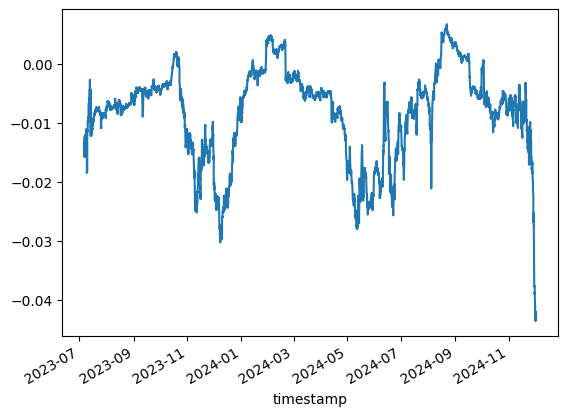

In [51]:
r2[1000:].plot()

In [426]:
all_preds_df

,timestamp,filename,pred,next_return
0,2024-01-02 00:00:00,MKRUSD_720.parquet,0.000457,0.103857
1,2024-01-02 00:00:00,MOVRUSD_720.parquet,-0.003323,-0.023942
2,2024-01-02 00:00:00,NANOUSD_720.parquet,-0.000212,0.154890
3,2024-01-02 00:00:00,POLISUSD_720.parquet,-0.002470,-0.085673
4,2024-01-02 00:00:00,OCEANUSD_720.parquet,-0.000570,-0.031448
...,...,...,...,...
69115,2024-12-27 12:00:00,ENJUSD_720.parquet,-0.001681,0.009050
69116,2024-12-27 12:00:00,EOSUSD_720.parquet,-0.001525,0.000000
69117,2024-12-27 12:00:00,ETCUSD_720.parquet,-0.001219,0.008452
69118,2024-12-27 12:00:00,ETHUSD_720.parquet,-0.000677,0.008290


In [428]:
all_preds_df.sort_values('timestamp', inplace=True)
all_preds_df.set_index('timestamp', inplace=True)
all_preds_df['error'] = all_preds_df['pred'] - all_preds_df['next_return']
all_preds_df['rolling_std'] = all_preds_df['error'].rolling(window='60D').std()
all_preds_df.reset_index(inplace=True)

In [441]:
all_preds_df['z_score'] = all_preds_df['pred'] / all_preds_df['rolling_std']

<Axes: >

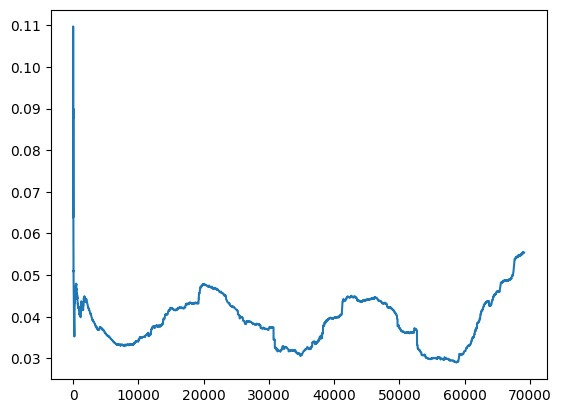

In [442]:
all_preds_df.rolling_std.plot()

In [670]:
all_preds_df['traded'] = np.where(
    (all_preds_df['pred'] > 0.01),
    1,
    0
)

In [671]:
all_preds_df['pnl'] = all_preds_df['traded'] * (all_preds_df['next_return'] - 0.005) * (10000)

In [672]:
all_preds_df.loc[all_preds_df.traded != 0].pnl.describe()

count     673.000000
mean      223.841936
std       876.368149
min     -2558.115366
25%      -183.575611
50%       112.348904
75%       477.760655
max      9423.813189
Name: pnl, dtype: float64

<Axes: title={'center': 'Cumulative PnL from XGB model'}>

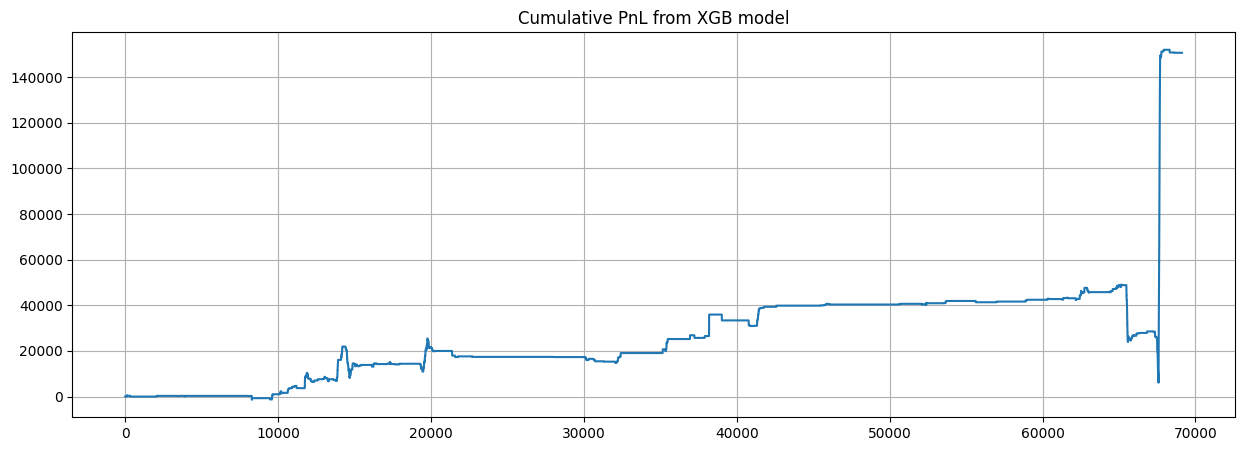

In [673]:
all_preds_df.pnl.cumsum().plot(figsize=(15, 5), title='Cumulative PnL from XGB model', grid=True)

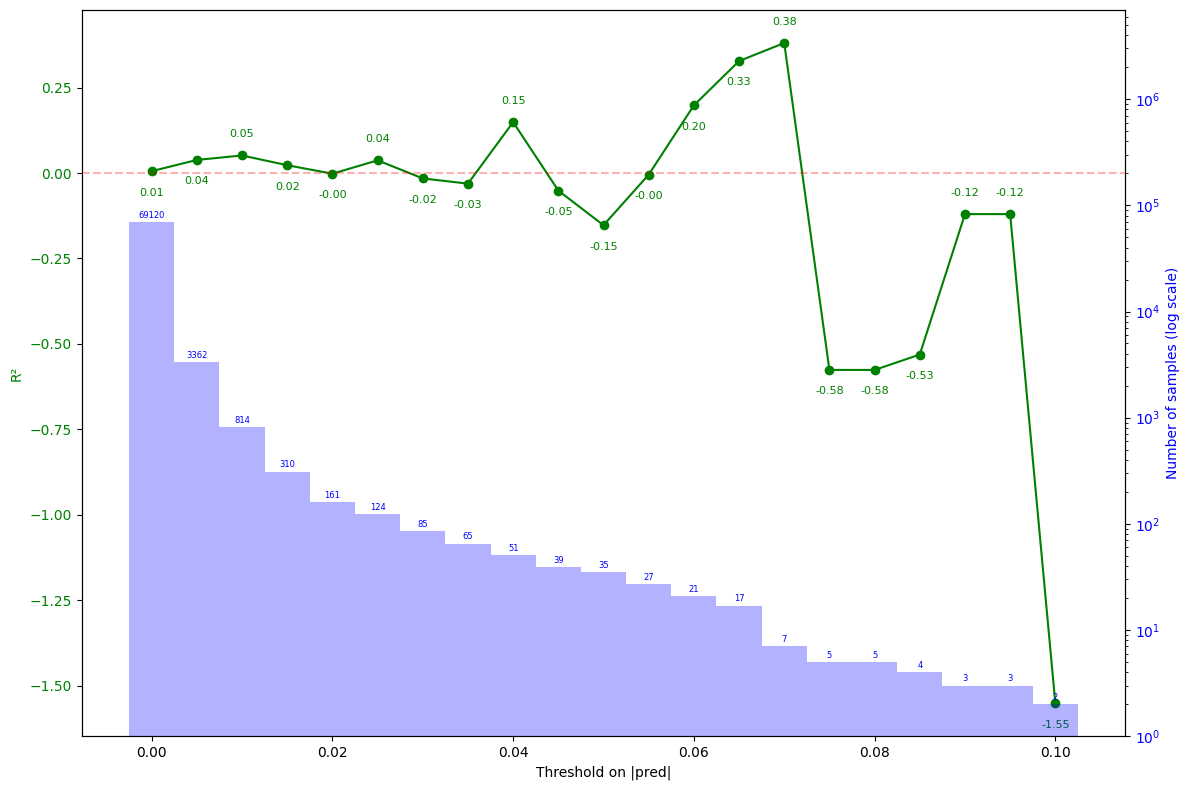

In [ ]:
r2_metrics = {}
count_metrics = {}

for thr in np.arange(0, 1, 0.005):
    subset = all_preds_df.loc[np.abs(all_preds_df['pred']) >= thr]
    n = len(subset)
    if n == 0:
        continue

    count_metrics[thr] = n

    r2_metrics[thr] = r2_score(subset['next_return'], subset['pred'])

r2_metrics = pd.Series(r2_metrics).sort_index()
count_metrics = pd.Series(count_metrics).sort_index()

fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.plot(
    r2_metrics.index,
    r2_metrics.values,
    marker='o',
    color='green',
    label='R²'
)
ax1.axhline(0, color='red', linestyle='--', alpha=0.3)
ax1.set_xlabel('Threshold on |pred|')
ax1.set_ylabel('R²', color='green')
ax1.tick_params(axis='y', labelcolor='green')

x_vals = r2_metrics.index.values
y_vals = r2_metrics.values
y_min, y_max = y_vals.min(), y_vals.max()
offset = (y_max - y_min) * 0.04
for i in range(len(y_vals)):
    y_curr = y_vals[i]
    y_next = y_vals[i + 1] if i < len(y_vals) - 1 else y_vals[i - 1]
    y_prev = y_vals[i - 1] if i > 0 else y_vals[i + 1]

    if y_next > y_curr and y_prev > y_curr:
        y_pos = y_curr - offset
        va = 'bottom'
    elif y_next <= y_curr and y_prev <= y_curr:
        y_pos = y_curr + offset
        va = 'top'
    else:
        y_pos = y_curr - offset
        va = 'bottom'

    ax1.text(
        x_vals[i],
        y_pos,
        f"{y_curr:.2f}",
        ha='center',
        va=va,
        fontsize=8,
        color='green'
    )


ax2 = ax1.twinx()
bars = ax2.bar(
    count_metrics.index,
    count_metrics.values,
    width=0.005,
    alpha=0.3,
    color='blue',
    label='Count'
)
ax2.set_ylabel('Number of samples (log scale)', color='blue')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='blue')

ax2.set_ylim(1, count_metrics.max() * 100)

for x, y in zip(count_metrics.index, count_metrics.values):
    ax2.text(
        x,
        y * 1.05,
        str(int(y)),
        ha='center',
        va='bottom',
        fontsize=6,
        color='blue'
    )

fig.tight_layout()
plt.show()


In [515]:
ax2.get_ylim()

(1.0, 6912000.0)

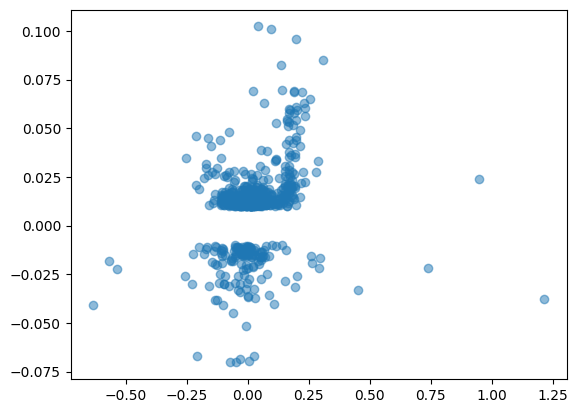

In [473]:
plt.scatter(tmp['next_return'], tmp['pred'], alpha=0.5)

In [454]:
all_preds_df.loc[all_preds_df.traded != 0]

,timestamp,filename,pred,next_return,error,rolling_std,z_score,traded,pnl
8286,2024-02-14 00:00:00,KEYUSD_720.parquet,0.044751,-0.160696,0.205447,0.033346,1.342033,1,-1606.958354
11744,2024-03-04 00:00:00,XDGUSD_720.parquet,0.052466,0.114557,-0.062091,0.035787,1.466055,1,1145.568211
11752,2024-03-04 00:00:00,SHIBUSD_720.parquet,0.085167,0.309398,-0.224231,0.035839,2.376408,1,3093.976394
37228,2024-07-14 12:00:00,CQTUSD_720.parquet,0.034848,-0.109914,0.144762,0.033508,1.039991,1,-1099.144461
40777,2024-08-02 00:00:00,CQTUSD_720.parquet,0.046174,-0.211970,0.258144,0.040042,1.153130,1,-2119.702507
65903,2024-12-11 00:00:00,KEYUSD_720.parquet,0.100875,0.095378,0.005497,0.048441,2.082431,1,953.775675
66153,2024-12-12 12:00:00,KEYUSD_720.parquet,0.102248,0.040394,0.061854,0.048719,2.098746,1,403.944222
66345,2024-12-13 12:00:00,KEYUSD_720.parquet,0.068988,0.022578,0.046411,0.048668,1.417517,1,225.778372
67594,2024-12-20 00:00:00,QTUMUSD_720.parquet,0.059827,0.170090,-0.110263,0.052500,1.139560,1,1700.904019
67618,2024-12-20 00:00:00,UNIUSD_720.parquet,0.095663,0.198756,-0.103093,0.052870,1.809405,1,1987.558410


In [456]:
df.loc[(df.filename == 'SHIBUSD_720.parquet') & (df.timestamp >= '2024-12-20')]

,timestamp,open,high,low,close,volume,trades,log_return,return,volume_change,close_to_high,close_to_low,log_price_range,ma_zscore_14,mom_2_1,mom_14_2,mom_12_7,mom_36_13,strev_6,ltrev_28,ema_diff_norm_10_21,ema_diff_norm_20_50,price_ema_diff_14,macd_hist,realized_vol_14,weighted_vol_14,volume_zscore_14,vwap_14,sto_osc_14,rsi,amihud_14,beta_market,filename,next_return,filename_id
149533,2024-12-20 00:00:00,0.000022,0.000023,0.000019,0.000019,1.377745e+11,4719.0,-0.147678,-0.137291,-0.146530,0.824468,1.003778,0.196787,-2.573000,-0.117479,-0.124373,-0.029265,-0.001050,0.209098,0.281094,-0.096519,-0.043088,-0.343377,-8.536627e-07,0.209412,0.077613,1.354722,0.000025,0.679612,15.194611,4.523947e-13,-0.048599,SHIBUSD_720.parquet,0.188574,SHIBUSD_720.parquet
149637,2024-12-20 12:00:00,0.000019,0.000023,0.000019,0.000022,1.310756e+11,4549.0,0.188574,0.207527,-0.048622,0.990300,1.213398,0.203172,-1.036375,-0.137291,-0.244304,-0.008006,-0.063190,0.293313,0.397473,-0.079388,-0.042654,-0.097502,-7.182646e-07,0.293957,0.103380,1.052487,0.000024,38.275194,31.705847,5.211914e-13,1.929232,SHIBUSD_720.parquet,0.026364,SHIBUSD_720.parquet
149741,2024-12-21 00:00:00,0.000022,0.000024,0.000022,0.000023,7.335902e+10,2575.0,0.026364,0.026714,-0.440331,0.961234,1.042024,0.080703,-0.709796,0.207527,-0.336188,-0.043952,-0.057290,0.137149,0.285851,-0.073286,-0.045834,-0.059753,-5.480658e-07,0.294627,0.102481,-0.133342,0.000024,46.571136,35.131894,5.214013e-13,2.125616,SHIBUSD_720.parquet,-0.061709,SHIBUSD_720.parquet
149845,2024-12-21 12:00:00,0.000023,0.000023,0.000021,0.000022,6.749314e+10,2448.0,-0.061709,-0.059844,-0.079961,0.940972,1.011666,0.072440,-1.042551,0.026714,-0.182678,-0.065686,-0.038421,0.040366,0.280050,-0.079255,-0.056102,-0.110249,-4.900866e-07,0.300025,0.103482,-0.249756,0.000024,32.446264,33.447489,5.665179e-13,2.430503,SHIBUSD_720.parquet,0.016015,SHIBUSD_720.parquet
149949,2024-12-22 00:00:00,0.000022,0.000022,0.000021,0.000022,2.505710e+10,1270.0,0.016015,0.016144,-0.628746,0.993685,1.055077,0.059948,-0.794283,-0.059844,-0.162368,-0.097973,-0.083854,0.112567,0.325661,-0.076217,-0.060402,-0.080262,-3.939622e-07,0.300453,0.103200,-1.130134,0.000024,36.028659,34.567901,6.050950e-13,2.547342,SHIBUSD_720.parquet,-0.023887,SHIBUSD_720.parquet
150053,2024-12-22 12:00:00,0.000022,0.000022,0.000021,0.000022,2.876430e+10,1731.0,-0.023887,-0.023604,0.147950,0.968919,1.024774,0.056046,-0.856745,0.016144,-0.221823,-0.101838,-0.192483,-0.021800,0.316263,-0.077612,-0.067607,-0.092193,-3.335915e-07,0.301141,0.103319,-1.049650,0.000023,30.706244,32.370905,6.362739e-13,2.699874,SHIBUSD_720.parquet,0.011096,SHIBUSD_720.parquet
150157,2024-12-23 00:00:00,0.000022,0.000022,0.000021,0.000022,6.087219e+10,2251.0,0.011096,0.011158,1.116241,0.974462,1.037691,0.062867,-0.655033,-0.023604,-0.173048,-0.209098,-0.147335,-0.156452,0.275025,-0.074155,-0.070933,-0.069456,-2.495336e-07,0.298149,0.102240,-0.425097,0.000023,34.358431,35.642983,5.773828e-13,2.609732,SHIBUSD_720.parquet,0.033902,SHIBUSD_720.parquet
150261,2024-12-23 12:00:00,0.000022,0.000023,0.000021,0.000023,4.887445e+10,1831.0,0.033902,0.034483,-0.197097,0.987275,1.062323,0.073265,-0.253398,0.011158,-0.209191,-0.293313,-0.105936,0.031612,0.204171,-0.065598,-0.069866,-0.029300,-1.219198e-07,0.299399,0.102608,-0.663048,0.000023,44.630872,36.353078,5.992873e-13,2.627429,SHIBUSD_720.parquet,-0.007137,SHIBUSD_720.parquet
150365,2024-12-24 00:00:00,0.000022,0.000023,0.000022,0.000022,3.613625e+10,1175.0,-0.007137,-0.007111,-0.260631,0.991127,1.019626,0.028348,-0.199374,0.034483,-0.202128,-0.137149,-0.122374,0.024284,0.171881,-0.061068,-0.071641,-0.031782,-3.149178e-08,0.299475,0.102450,-0.936068,0.000023,42.841163,35.796767,6.085497e-13,2.761006,SHIBUSD_720.parquet,0.049770,SHIBUSD_720.parquet
150469,2024-12-24 12:00:00,0.000022,0.000024,0.000022,0.000023,4.574753e+10,2111.0,0.049770,0.051030,0.265973,0.994073,1.057658,0.062002,0.551503,-0.007111,-0.145137,-0.040366,-0.156787,-0.030443,0.178072,-0.04919